# Example script demonstrating boundary profile fitting

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [2]:
# Functions

def csv_to_dataframe(folder):
    # Given a directory folder, reads all the csv's in the folder 
    # renames columns, trims and normalizes data, and
    # returns them as a single Dataframe.
    
    # get file names
    files = os.listdir(folder)
    files = [x for x in files if '.csv' in x] # only keep csvs
    
    # read files
    combined_data = []
    for file in files:       
        data = pd.read_csv(os.path.join(folder, file), index_col=None, header=0)
        
        # rename columns to be more readable
        strain_id_string = file[0:-4]
        data = data.rename({'Gray_Value':strain_id_string}, axis='columns')
        
        # trim data to get rid of excess points at extremes
        new_data = data[strain_id_string][20:-11] # trimming 30 total points

        # min-max normalize data
        new_data = new_data - np.min(new_data)
        new_data = new_data / np.max(new_data)
        
        combined_data.append(new_data)

    x_positions = data['Distance_(microns)'][30:-1]/1000 - np.min(data['Distance_(microns)'][30:-1]/1000)
    combined_df = pd.concat(combined_data, axis=1, ignore_index=False)
    
    return combined_df, x_positions

def hill_gauss_func(x, k_a, n, y, z, a, b):
    # Eq for hill func
    return z / (1 + (k_a / (1*x)) ** n) + y + a*np.exp(-(x)**2/b)

def first_d_hf(x, k_a, n, y, z, a, b):
    # first derivative of hill_gauss_func
    return (n * k_a**n * x**(n - 1)) / (x**n + k_a**n)**2 + (-2 * x * a / b) * np.exp(-x**2 / b)
    
def second_d_hf(x, k_a, n, y, z, a, b):
    # second derivative of hill_gauss_func
    return ( -2 * n**2 * k_a**n * x**(2*n-2) + n * k_a**n * (n-1) * x**(n-2) * (x**n + k_a**n) ) / (x**n + k_a**n)**3 + np.exp(-x**2 / b) * (2 * a / b) * ((2 / b) * x**2 - 1)

def curvature(x, k_a, n, y, z, a, b):
    # equation for curvature
    return (second_d_hf(x, k_a, n, y, z, a, b) ** 2) / ((1 + first_d_hf(x, k_a, n, y, z, a, b)**2)**3)


In [3]:
# Set path to data

data_folder = os.path.normpath(r'BoundaryData')


Text(0.5, 1.0, 'Boundary profiles:\n data, fits, and widths')

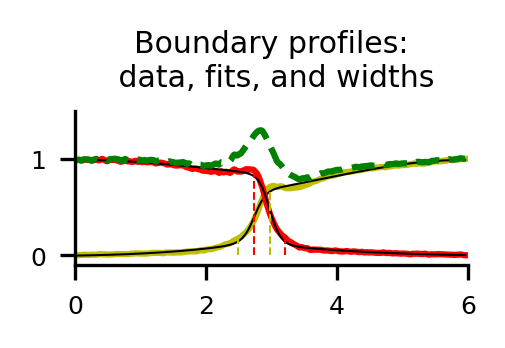

In [4]:
# Calculate best fit and plot data

plt.rcParams.update({'font.size': 6})
plt.tight_layout = {'pad': 0} 
fig, ax = plt.subplots(figsize=(3.5/2.54, 1.5/2.54), dpi=300)

fluor_df, x_df = csv_to_dataframe(data_folder)
plotted_vals = []

for key in fluor_df:
    if '_R' in key:
        color = 'r'
        direction = 1
    else: # reverse direction for yellow strain
        color = 'y'
        direction = -1

    # fit data to hill_gauss_func 
    popt, pcov = curve_fit(hill_gauss_func, x_df, fluor_df[key][::direction], 
                           bounds = ([0, -100, -1, 0, 0, 1], [10, 0, 1, 2, 1, 20]))
    
    # plot data and fit
    plt.plot(x_df[::direction], fluor_df[key][::direction], color)
    plt.plot(x_df[::direction], hill_gauss_func(x_df, *popt), 'k-', linewidth='0.5')

    # store the raw plotted data in list
    plotted_vals.append(fluor_df[key])

    # find the max curvature of the plots
    swap_index = next(x[0] for x in enumerate(x_df) if x[1] > popt[0])
    first_peak = np.argmax(curvature(x_df, *popt)[0:swap_index])
    second_peak = np.argmax(curvature(x_df, *popt)[swap_index:])
    
    # plot max curvatures
    plt.vlines(x_df[::direction].iloc[first_peak],
               0, fluor_df[key][::direction].iloc[first_peak],
               color, '--', linewidths=0.5, zorder=100)
    plt.vlines(x_df[::direction].iloc[swap_index+second_peak],
               0, fluor_df[key][::direction].iloc[swap_index+second_peak],
               color, '--', linewidths=0.5, zorder=100)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(top = 0.97, bottom = 0.1,
                    right = 0.99, left = 0.04, 
                    hspace = 0, wspace = 2)
plt.tight_layout = {'pad': 0} 
plt.ylim([-0.1, 1.5])
plt.xlim([0, 6])

plt.plot(x_df, np.add(plotted_vals[0], plotted_vals[1]), 'g--')
plt.title('Boundary profiles:\n data, fits, and widths')